# Pre-RA Flow PB1: Cell type level subclustering

This object excludes the naive b cells from the downstream analysis and includes IG positive markers for clustering

## Setup

In [1]:
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce

print(sy.__version__)
print(anndata.__version__)


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


1.5.1
0.10.6


In [2]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PB1"
# define l1 cell types to subset
cell_types = ["total_b_cells"]
# define additional l2 cell types to subset out
l2_cell_types = ['naive_b_cells']
data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/labelled-expr/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = -1

## Functions

In [3]:
def subset_anndata_by_cell_types(anndata_obj, cell_types):
    """
    Subset Anndata object by specific cell types from the metadata column "labels".

    Parameters:
        anndata_obj (anndata.AnnData): Anndata object containing single-cell genomics data.
        cell_types (list): List of cell types to subset.

    Returns:
        dict: Dictionary containing cell types as keys and corresponding Anndata objects as values.
    """
    split_anndata = {}
    for cell_type in cell_types:
        subset_indices = anndata_obj.obs['l1_labels'] == cell_type
        subset_anndata = anndata_obj[subset_indices].copy()
        split_anndata[cell_type] = subset_anndata
    return split_anndata

In [4]:
def subsample_adata_by_group(anndata_obj, target_cells,cluster_key ):
    """
    Subsample Anndata object by specific groupings from the metadata columns by fix target cells.

    Parameters:
        anndata_obj (anndata.AnnData): Anndata object containing single-cell genomics data.
        cluster_key (list): List of cell groupings from metadata
        target_cells (num): an integer of the fixed targeted number of cells per groupings

    Returns:
        Anndata object
    """
    total_cells = len(anndata_obj)
    if total_cells < 5000000:  # Check if total cells is less than 5 million
        print("Total cells less than 5 million. No downsampling performed.")
        return anndata_obj  # Return the original Anndata object
    
    grouped = anndata_obj.obs.groupby(cluster_key)

    downsampled_indices = []
    for _, group in grouped:
        if len(group) > target_cells:
            downsampled_indices.extend(group.sample(target_cells).index)
        else:
            downsampled_indices.extend(group.index)
        
    adata_downsampled = adata_sub_celltype[downsampled_indices]
    return(adata_downsampled)

In [5]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [6]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

## Read in data 

In [7]:
print("READING IN ADATA")
adata_file = output_path + "adata_preprocess_unscaled_" + panel + ".h5ad"
print(adata_file)
adata = sc.read_h5ad(adata_file)
print(adata)

READING IN ADATA
/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_preprocess_unscaled_PB1.h5ad
AnnData object with n_obs × n_vars = 57762311 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels'


In [8]:
cell_labels_to_subset_list = adata.obs['l1_labels'].unique()
print(cell_labels_to_subset_list)

['unknown', 't_cells', 'total_b_cells', 'debris', 'total_nk_cells', 'total_myeloid_cells']
Categories (6, object): ['debris', 't_cells', 'total_b_cells', 'total_myeloid_cells', 'total_nk_cells', 'unknown']


In [9]:
adata.obs['labels'].unique()

['Unknown', 't_cells', 'naive_b_cells', 'debris', 'nk_cells', ..., 'transitional_b_cells', 'non_switched_effector_b_cells', 'plasmablasts', 'other_b_cells', 'switched_effector_b_cells']
Length: 14
Categories (14, object): ['Unknown', 'cd14_monocytes', 'debris', 'naive_b_cells', ..., 'switched_effector_b_cells', 'switched_memory_b_cells', 't_cells', 'transitional_b_cells']

In [10]:
print(pd.crosstab(adata.obs['sample_id'], adata.obs['l1_labels'], margins=True)) 


l1_labels    debris   t_cells  total_b_cells  total_myeloid_cells  \
sample_id                                                           
PB00052-02    16422    135200          32554                13738   
PB00055-02    13004    141077          45016                13014   
PB00056-02    15007    121878          24877                40779   
PB00057-02     6101     96300          23780                25493   
PB00058-03     3604     98321          11800                70936   
...             ...       ...            ...                  ...   
PB04671-00    12696    213626          55552                80386   
PB04906-00    16244    189658          74082                31518   
PB04933-00    28682    189046          76284                43810   
PB04937-00    25098    259354          50024                13830   
All         1926711  19346675        4270985              7061586   

l1_labels   total_nk_cells   unknown       All  
sample_id                                       
PB00

In [11]:
print(pd.crosstab(adata.obs['l1_labels'], adata.obs['panel'], margins=True)) 


panel                     PB1       All
l1_labels                              
debris                1926711   1926711
t_cells              19346675  19346675
total_b_cells         4270985   4270985
total_myeloid_cells   7061586   7061586
total_nk_cells        5813166   5813166
unknown              19343188  19343188
All                  57762311  57762311


In [12]:
### read in metadata 
meta = pd.read_csv("/home/jupyter/projects/pre-ra/flow/raw-data/2023-11-22_ALTRA_Metadata_labs_long-model-vars.csv")

In [13]:
meta["sample.sampleKitGuid"]

0      KT00052
1      KT00055
2      KT00056
3      KT00057
4      KT00058
        ...   
152    KT04924
153    KT04933
154    KT04937
155    KT02968
156    KT04906
Name: sample.sampleKitGuid, Length: 157, dtype: object

In [14]:
meta = meta[[ 'sample.sampleKitGuid','Status_Xsec','Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv','bmi_conv','Age2023']]

In [15]:
meta.head()

,sample.sampleKitGuid,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
0,KT00052,at_risk,pre,Female,CU1009,-714.0,58.0,25.648918,60
1,KT00055,early_RA,NaN,Female,CU1008,NaN,NaN,NaN,57
2,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
3,KT00057,at_risk,pre,Female,CU1003,-615.0,23.0,23.143062,25
4,KT00058,at_risk,NaN,Female,CU1002,NaN,NaN,NaN,82


In [16]:
### add sample.sampleKitGuid to column metadata of anndata before merging metadata
sample_id = adata.obs["sample_id"]

sliced_ids = [ids[2:7] for ids in sample_id]
sampleKitGuid = ["KT" + ids for ids in sliced_ids]

In [17]:
adata.obs["sample.sampleKitGuid"] = sampleKitGuid

In [18]:
adata.obs[["sample.sampleKitGuid", "sample_id"]].head()

,sample.sampleKitGuid,sample_id
0-0,KT00467,PB00467-01
1-0,KT00467,PB00467-01
2-0,KT00467,PB00467-01
3-0,KT00467,PB00467-01
4-0,KT00467,PB00467-01


In [19]:
### merge meta info back to adata obj
adata.obs = pd.merge(adata.obs, meta, on='sample.sampleKitGuid', how='inner')


In [20]:
adata.obs.head()

,Unnamed: 0,sample_id,cell_id,barcode,Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,...,sample.sampleKitGuid,l1_labels,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
0,0,PB00467-01,1,908e13a82a8411eda605fe22d8c79dde,48450.0,740557.9375,564999.0,697357.4375,716652.3750,1189311.0,...,KT00467,unknown,NaN,pre,Female,CU1033,-616.0,49.0,31.161374,49
1,1,PB00467-01,2,908e13d02a8411eda605fe22d8c79dde,48450.0,731824.6250,459221.0,560115.3750,708948.3750,996820.0,...,KT00467,t_cells,NaN,pre,Female,CU1033,-616.0,49.0,31.161374,49
2,2,PB00467-01,3,908e13f82a8411eda605fe22d8c79dde,48455.0,845166.8750,495960.0,698614.9375,763026.3750,634781.0,...,KT00467,unknown,NaN,pre,Female,CU1033,-616.0,49.0,31.161374,49
3,3,PB00467-01,4,908e14202a8411eda605fe22d8c79dde,48456.0,757639.6875,362719.0,458017.1875,725696.1250,949282.0,...,KT00467,t_cells,NaN,pre,Female,CU1033,-616.0,49.0,31.161374,49
4,4,PB00467-01,6,908e14702a8411eda605fe22d8c79dde,48460.0,746102.8750,502148.0,624423.4375,744195.0625,1243487.0,...,KT00467,unknown,NaN,pre,Female,CU1033,-616.0,49.0,31.161374,49


In [21]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57762311 entries, 0 to 57762310
Data columns (total 28 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   Unnamed: 0             int64   
 1   sample_id              category
 2   cell_id                int64   
 3   barcode                object  
 4   Time                   float64 
 5   SSC-W                  float64 
 6   SSC-H                  float64 
 7   SSC-A                  float64 
 8   FSC-W                  float64 
 9   FSC-H                  float64 
 10  FSC-A                  float64 
 11  SSC-B-W                float64 
 12  SSC-B-H                float64 
 13  SSC-B-A                float64 
 14  Viability_logicle      float64 
 15  labels                 category
 16  batch                  category
 17  panel                  category
 18  sample.sampleKitGuid   object  
 19  l1_labels              category
 20  Status_Xsec            object  
 21  Status_Long            object

## Subset by sample selection 

In [22]:
meta[meta['days_to_conversion'] <= -750]

,sample.sampleKitGuid,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
7,KT00064,at_risk,pre,Female,CU1010,-1144.0,62.0,24.550265,62
16,KT00075,at_risk,pre,Male,CU1021,-1037.0,68.0,25.660730,69
27,KT00093,NaN,pre,Male,CU1021,-848.0,68.0,25.660730,69
29,KT00097,NaN,pre,Female,CU1010,-1035.0,62.0,24.550265,62
48,KT00424,NaN,pre,Male,CU1021,-778.0,68.0,25.660730,69
51,KT00443,at_risk,pre,Female,CU1033,-818.0,49.0,31.161374,49


In [23]:
len(meta['sample.sampleKitGuid'].unique())

157

In [24]:
len(adata.obs['sample.sampleKitGuid'].unique())

138

In [25]:
samples_to_remove = meta[meta['days_to_conversion'] <= -750]["sample.sampleKitGuid"]

In [26]:
len(samples_to_remove)

6

In [27]:
# Convert the column to string type if it's not already
adata.obs['sample.sampleKitGuid'] = adata.obs['sample.sampleKitGuid'].astype(str)

In [28]:
# Define the condition based on the metadata in the "obs" slot
condition = ~adata.obs['sample.sampleKitGuid'].isin(samples_to_remove)


In [29]:
# Use boolean indexing with the negation operator (~) to remove samples that meet the condition
adata_sub = adata[condition]

In [30]:
# check if samples to remove is still in filtered adata
adata_sub.obs['sample.sampleKitGuid'].isin(samples_to_remove).any()

False

In [31]:
len(adata_sub.obs['sample.sampleKitGuid'].unique())

132

In [32]:
adata_sub.write_h5ad(output_path + "adata_preprocess_unscaled_sample_select_sub_" + panel + ".h5ad")

In [33]:
adata_sub

AnnData object with n_obs × n_vars = 55723956 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'

In [34]:
print(pd.crosstab(adata_sub.obs['l1_labels'], adata_sub.obs['panel'], margins=True)) 


panel                     PB1       All
l1_labels                              
debris                1841686   1841686
t_cells              18712875  18712875
total_b_cells         4129003   4129003
total_myeloid_cells   6689022   6689022
total_nk_cells        5565390   5565390
unknown              18785980  18785980
All                  55723956  55723956


In [35]:
cellcount_sampleselect = pd.crosstab(adata_sub.obs['sample_id'], adata_sub.obs['l1_labels'], margins=True)

cellcount_sampleselect.reset_index().rename_axis(None, axis=1)

cellcount_sampleselect = cellcount_sampleselect.add_prefix("sample_select_")

In [36]:
cellcount_sampleselect

l1_labels,sample_select_debris,sample_select_t_cells,sample_select_total_b_cells,sample_select_total_myeloid_cells,sample_select_total_nk_cells,sample_select_unknown,sample_select_All
sample_id,,,,,,,
PB00052-02,16422,135200,32554,13738,66064,196588,460566
PB00055-02,13004,141077,45016,13014,19797,157100,389008
PB00056-02,15007,121878,24877,40779,42217,151930,396688
PB00057-02,6101,96300,23780,25493,24063,113278,289015
PB00058-03,3604,98321,11800,70936,21980,56482,263123
...,...,...,...,...,...,...,...
PB04671-00,12696,213626,55552,80386,52792,213414,628466
PB04906-00,16244,189658,74082,31518,66400,217178,595080
PB04933-00,28682,189046,76284,43810,20584,128288,486694


## Subset Cell Types 

### Sample composition in cell types

In [37]:
# subset at l1 label level
adata_sub_celltype = adata_sub[adata_sub.obs['l1_labels'].isin(cell_types)]

In [38]:
adata_sub_celltype

View of AnnData object with n_obs × n_vars = 4129003 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'

In [40]:
pd.crosstab(adata_sub_celltype.obs['labels'], adata_sub_celltype.obs['panel'], margins=True)

panel,PB1,All
labels,,
naive_b_cells,2274984,2274984
non_switched_effector_b_cells,52241,52241
non_switched_memory_b_cells,475711,475711
other_b_cells,28506,28506
plasmablasts,57317,57317
surface_ig_neg_memory_b_cells,233122,233122
switched_effector_b_cells,35021,35021
switched_memory_b_cells,478418,478418
transitional_b_cells,493683,493683


In [41]:
# additional subset at l2 label level
adata_sub_celltype = adata_sub_celltype[~adata_sub_celltype.obs['labels'].isin(l2_cell_types)]

In [42]:
pd.crosstab(adata_sub_celltype.obs['labels'], adata_sub_celltype.obs['panel'], margins=True)

panel,PB1,All
labels,,
non_switched_effector_b_cells,52241,52241
non_switched_memory_b_cells,475711,475711
other_b_cells,28506,28506
plasmablasts,57317,57317
surface_ig_neg_memory_b_cells,233122,233122
switched_effector_b_cells,35021,35021
switched_memory_b_cells,478418,478418
transitional_b_cells,493683,493683
All,1854019,1854019


In [43]:
meta_adata_type_sub = adata_sub_celltype.obs[adata_sub_celltype.obs['l1_labels'].isin(cell_types)]

In [44]:
pd.crosstab(meta_adata_type_sub['sample_id'], meta_adata_type_sub['l1_labels'], margins=True)


l1_labels,total_b_cells,All
sample_id,,
PB00052-02,13748,13748
PB00055-02,15998,15998
PB00056-02,13741,13741
PB00057-02,11891,11891
PB00058-03,7335,7335
...,...,...
PB04671-00,30302,30302
PB04906-00,26936,26936
PB04933-00,28360,28360


In [45]:
celltype_counts = pd.crosstab(meta_adata_type_sub['sample_id'], meta_adata_type_sub['l1_labels'], margins=True)

celltype_counts.reset_index().rename_axis(None, axis=1)

,sample_id,total_b_cells,All
0,PB00052-02,13748,13748
1,PB00055-02,15998,15998
2,PB00056-02,13741,13741
3,PB00057-02,11891,11891
4,PB00058-03,7335,7335
...,...,...,...
128,PB04671-00,30302,30302
129,PB04906-00,26936,26936
130,PB04933-00,28360,28360
131,PB04937-00,31138,31138


In [46]:
celltype_counts.describe()

l1_labels,total_b_cells,All
count,1.330000e+02,1.330000e+02
mean,2.787998e+04,2.787998e+04
std,1.597840e+05,1.597840e+05
min,1.398000e+03,1.398000e+03
25%,7.486000e+03,7.486000e+03
50%,1.237600e+04,1.237600e+04
75%,1.702800e+04,1.702800e+04
max,1.854019e+06,1.854019e+06


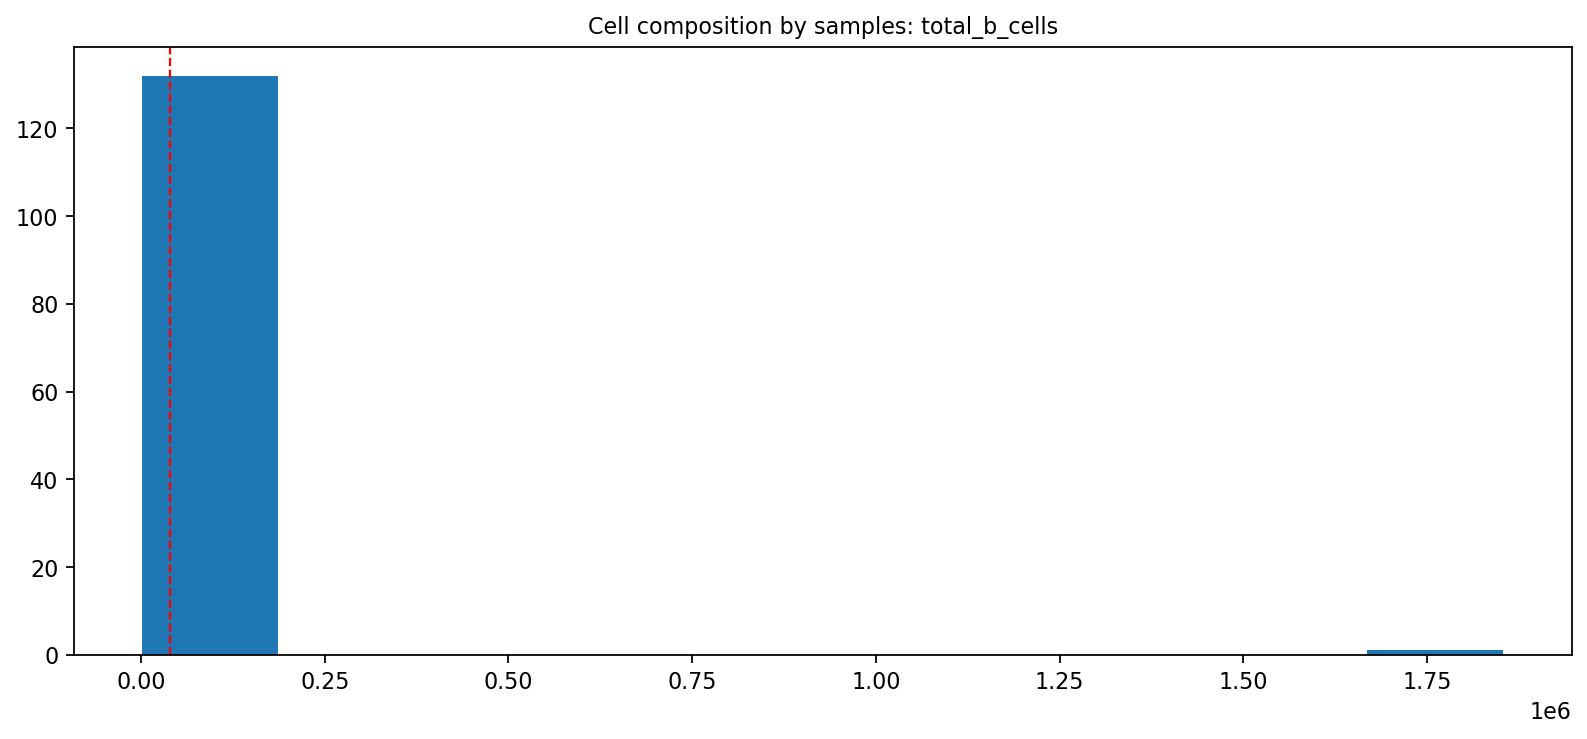

In [47]:
for ct in cell_types:
    plt.figure(figsize=(12, 5))
    plt.title("Cell composition by samples: " + ct)
    plt.hist(celltype_counts[[ct]])
    plt.axvline(40000, color='red', linestyle='dashed', linewidth=1)

### Conditional cell type subsampling

In [48]:
adata_downsampled = subsample_adata_by_group(adata_sub_celltype, target_cells = 40000,cluster_key= ["sample_id", "l1_labels"] )

Total cells less than 5 million. No downsampling performed.


In [49]:
adata_downsampled

View of AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'

In [50]:
celltype_counts_downsample =pd.crosstab(adata_downsampled.obs['sample_id'], adata_downsampled.obs["l1_labels"],margins=True)

In [51]:
celltype_counts_downsample.reset_index().rename_axis(None, axis=1)

,sample_id,total_b_cells,All
0,PB00052-02,13748,13748
1,PB00055-02,15998,15998
2,PB00056-02,13741,13741
3,PB00057-02,11891,11891
4,PB00058-03,7335,7335
...,...,...,...
128,PB04671-00,30302,30302
129,PB04906-00,26936,26936
130,PB04933-00,28360,28360
131,PB04937-00,31138,31138


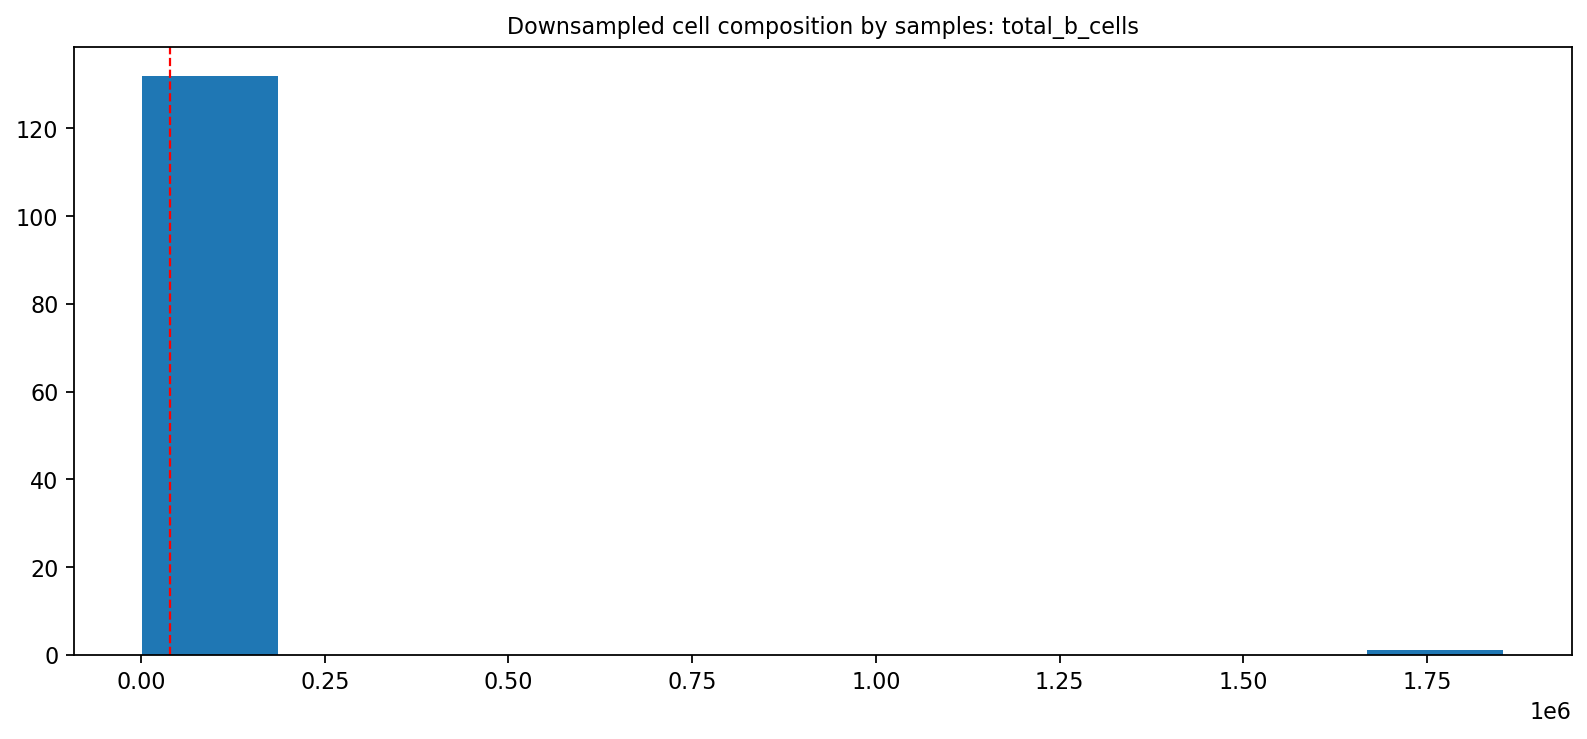

In [52]:
for ct in cell_types:
    plt.figure(figsize=(12, 5))
    plt.title("Downsampled cell composition by samples: " + ct)
    plt.hist(celltype_counts_downsample[[ct]])
    plt.axvline(40000, color='red', linestyle='dashed', linewidth=1)

In [53]:
celltype_counts_downsample = celltype_counts_downsample.add_prefix("downsample_")

In [54]:
adata_downsampled_celltypes = subset_anndata_by_cell_types(adata_downsampled,cell_types)

In [55]:
adata_downsampled_celltypes

{'total_b_cells': AnnData object with n_obs × n_vars = 1854019 × 24
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

In [66]:
filenames = [output_path + "adata_preprocess_unscaled_downsmpl_celltypes_" + cell_type + "_" + panel + "_igPos_non_naive_b.h5ad" for cell_type in cell_types]

In [67]:
save_anndata_list(adata_downsampled_celltypes, filenames)

AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'


In [59]:
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_preprocess_unscaled_downsmpl_celltypes_total_b_cells_PB1igPos_non_naive_b.h5ad',
  'total_b_cells')]

In [60]:
### check anndata after exporting

adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_b_cells': AnnData object with n_obs × n_vars = 1854019 × 24
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

## Cell Frequency Tables

In [61]:
cellcount_sampleselect.reset_index(inplace=True)

In [62]:
celltype_counts_downsample.reset_index(inplace=True)

In [63]:
### merge total counts (after sample selection) to 
cellcounts_df = pd.merge(cellcount_sampleselect, celltype_counts_downsample)

In [64]:
cellcounts_df

l1_labels,sample_id,sample_select_debris,sample_select_t_cells,sample_select_total_b_cells,sample_select_total_myeloid_cells,sample_select_total_nk_cells,sample_select_unknown,sample_select_All,downsample_total_b_cells,downsample_All
0,PB00052-02,16422,135200,32554,13738,66064,196588,460566,13748,13748
1,PB00055-02,13004,141077,45016,13014,19797,157100,389008,15998,15998
2,PB00056-02,15007,121878,24877,40779,42217,151930,396688,13741,13741
3,PB00057-02,6101,96300,23780,25493,24063,113278,289015,11891,11891
4,PB00058-03,3604,98321,11800,70936,21980,56482,263123,7335,7335
...,...,...,...,...,...,...,...,...,...,...
128,PB04671-00,12696,213626,55552,80386,52792,213414,628466,30302,30302
129,PB04906-00,16244,189658,74082,31518,66400,217178,595080,26936,26936
130,PB04933-00,28682,189046,76284,43810,20584,128288,486694,28360,28360
131,PB04937-00,25098,259354,50024,13830,139396,248400,736102,31138,31138


In [65]:
cellcounts_df.to_csv(output_path + "counts_freq_celltypes_sample_select_" + panel + "_igPos_non_naive_b.csv")